In [1]:
import numpy as np
import pandas as pd
import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2025-12-21 21:40:25.354470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766353225.375769     142 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766353225.382238     142 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766353225.399085     142 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766353225.399103     142 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766353225.399105     142 computation_placer.cc:177] computation placer alr

In [2]:
BASE_DIR = '/kaggle/input/food41'
IMAGES_DIR = os.path.join(BASE_DIR, 'images')
META_DIR = os.path.join(BASE_DIR, 'meta/meta')

In [3]:
def load_data_to_df(json_path, image_dir):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    df_data = []
    for food_class, images in data.items():
        for img_name in images:
            full_path = os.path.join(image_dir, img_name + '.jpg')
            df_data.append([food_class, full_path])
            
    return pd.DataFrame(df_data, columns=['label', 'path'])

train_df = load_data_to_df(os.path.join(META_DIR, 'train.json'), IMAGES_DIR)
test_df = load_data_to_df(os.path.join(META_DIR, 'test.json'), IMAGES_DIR)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Training images: {len(train_df)}")
print(f"Testing images: {len(test_df)}")
train_df

Training images: 75750
Testing images: 25250


,label,path
0,frozen_yogurt,/kaggle/input/food41/images/frozen_yogurt/2584...
1,donuts,/kaggle/input/food41/images/donuts/3570357.jpg
2,omelette,/kaggle/input/food41/images/omelette/3520398.jpg
3,donuts,/kaggle/input/food41/images/donuts/3420049.jpg
4,fried_rice,/kaggle/input/food41/images/fried_rice/3840604...
...,...,...
75745,deviled_eggs,/kaggle/input/food41/images/deviled_eggs/31852...
75746,greek_salad,/kaggle/input/food41/images/greek_salad/226107...
75747,filet_mignon,/kaggle/input/food41/images/filet_mignon/15930...
75748,hot_and_sour_soup,/kaggle/input/food41/images/hot_and_sour_soup/...


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 60600 validated image filenames belonging to 101 classes.
Found 15150 validated image filenames belonging to 101 classes.
Found 25250 validated image filenames belonging to 101 classes.


In [5]:
base_model = MobileNetV3Large(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(101, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1766353489.057681     142 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,093,413 (11.80 MB)

 Trainable params: 97,061 (379.14 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=5
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1766353498.324891     197 service.cc:152] XLA service 0x7e10b41429e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766353498.324926     197 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766353499.697569     197 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1766353506.098959     197 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1893/1893 ━━━━━━━━━━━━━━━━━━━━ 1178s 616ms/step - accuracy: 0.3449 - loss: 2.8337 - val_accuracy: 0.5688 - val_loss: 1.6924
Epoch 2/5
   1/1893 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.4375 - loss: 1.9662

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1893/1893 ━━━━━━━━━━━━━━━━━━━━ 171s 90ms/step - accuracy: 0.4375 - loss: 1.9662 - val_accuracy: 0.5735 - val_loss: 1.6946
Epoch 3/5
1893/1893 ━━━━━━━━━━━━━━━━━━━━ 860s 454ms/step - accuracy: 0.5615 - loss: 1.7254 - val_accuracy: 0.5978 - val_loss: 1.6037
Epoch 4/5
1893/1893 ━━━━━━━━━━━━━━━━━━━━ 169s 89ms/step - accuracy: 0.5625 - loss: 1.6148 - val_accuracy: 0.5968 - val_loss: 1.5968
Epoch 5/5
1893/1893 ━━━━━━━━━━━━━━━━━━━━ 846s 447ms/step - accuracy: 0.5871 - loss: 1.6176 - val_accuracy: 0.6069 - val_loss: 1.5572


In [7]:
results = model.evaluate(test_generator)
print(f"Test Accuracy: {results[1]*100:.2f}%")

790/790 ━━━━━━━━━━━━━━━━━━━━ 184s 233ms/step - accuracy: 0.6737 - loss: 1.1822
Test Accuracy: 68.19%


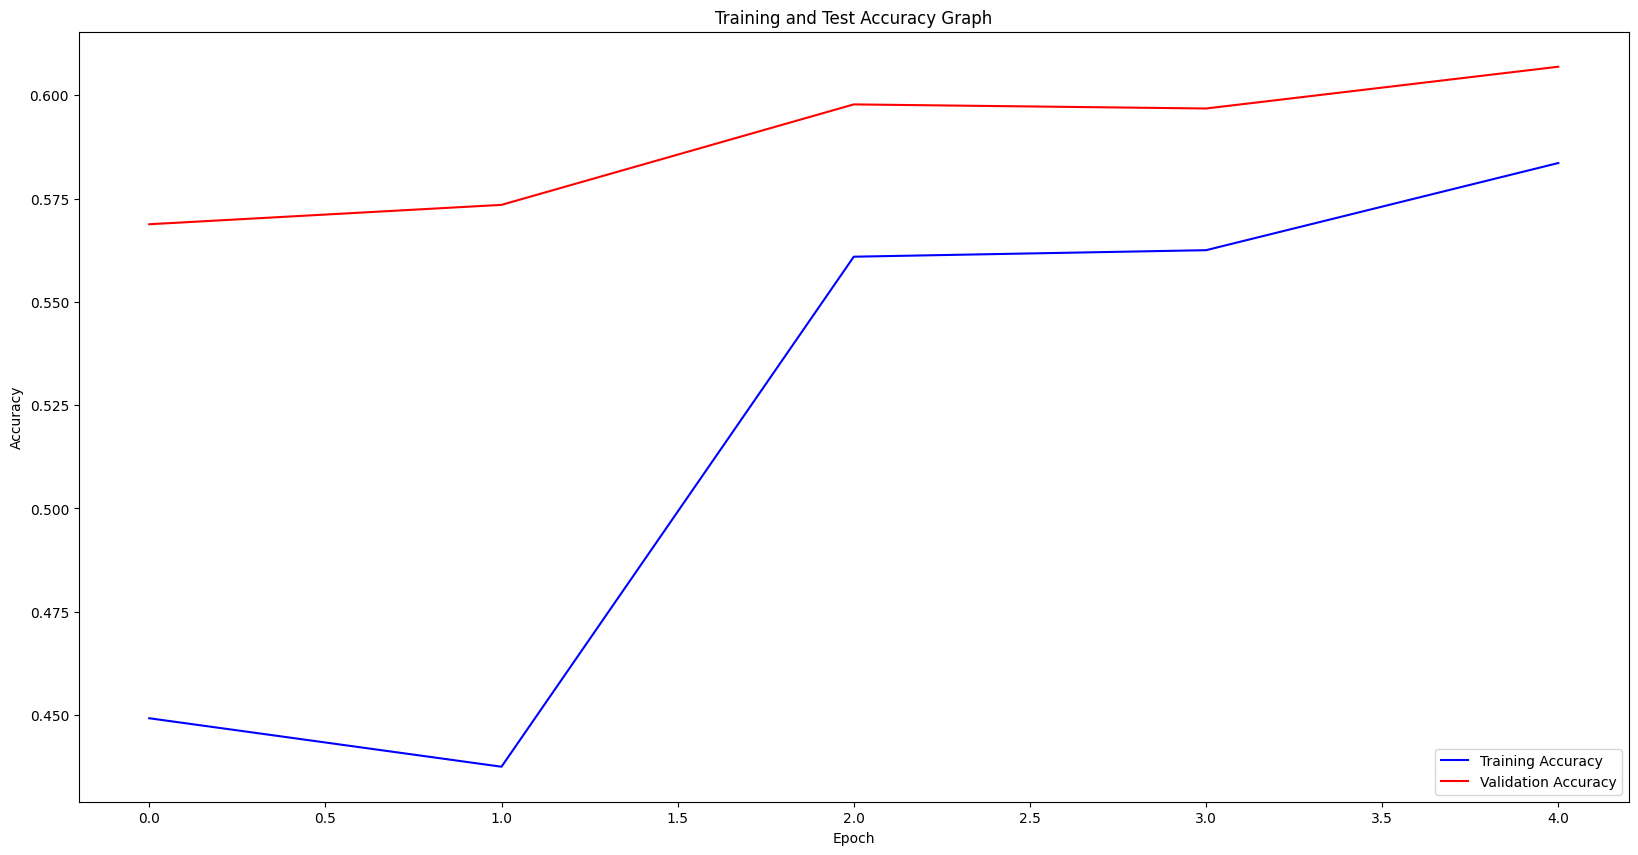

In [8]:
plt.figure(figsize=(20, 10))
plt.plot(history.history["accuracy"], color="b", label="Training Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy Graph");

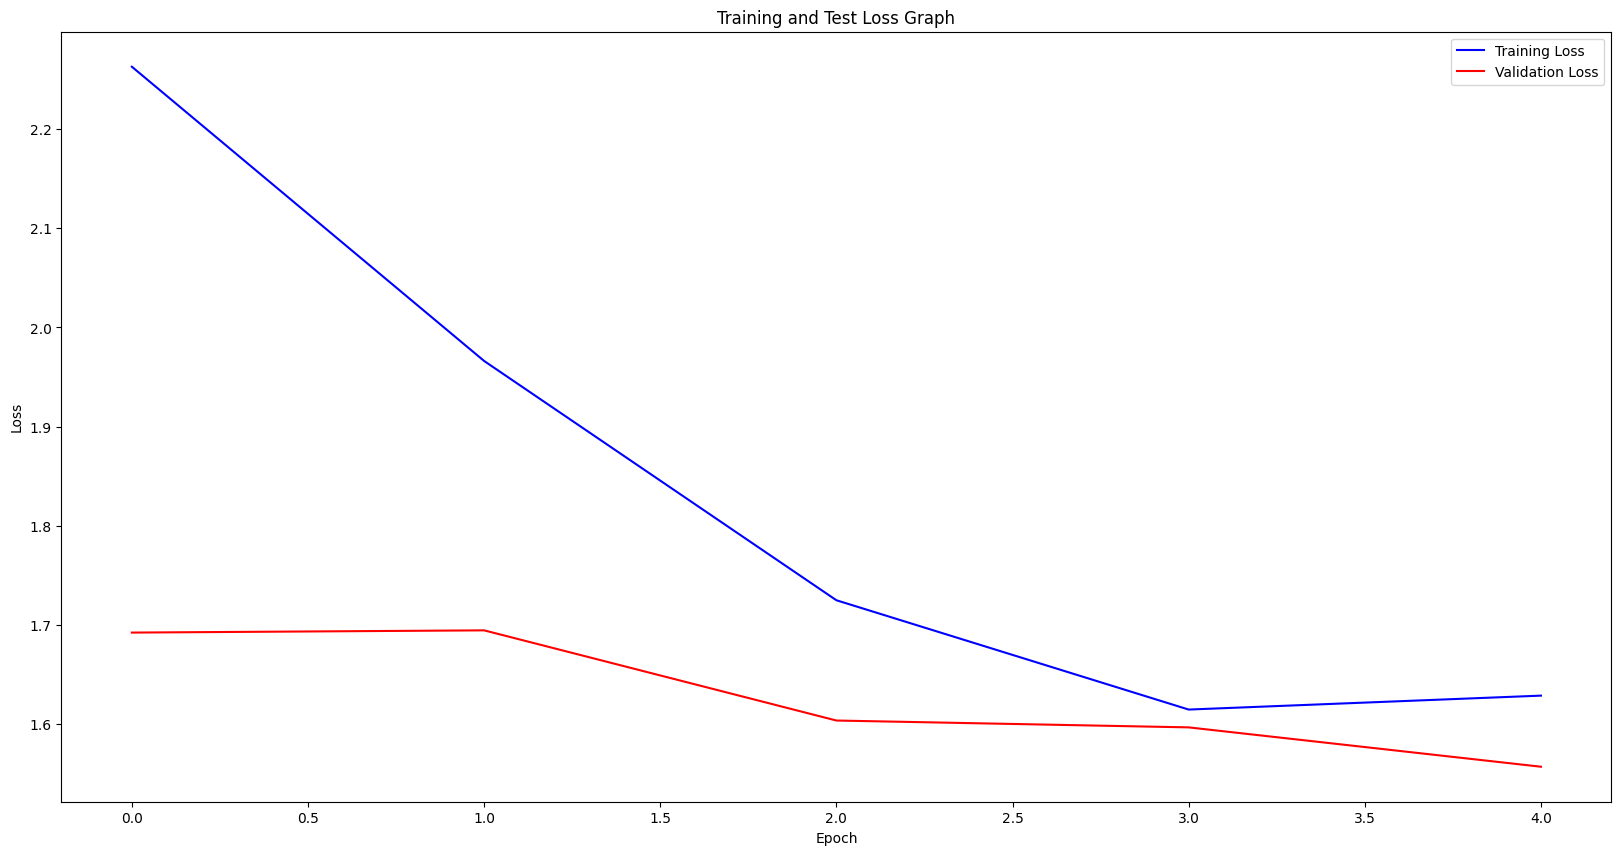

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(history.history["loss"], color="b", label="Training Loss")
plt.plot(history.history["val_loss"], color="r", label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss Graph");